In [71]:
import pandas as pd
import gensim
from gensim import corpora
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from gensim import corpora
from gensim.models import LdaMulticore, Word2Vec
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
#from pyLDAvis import gensim_models
#pyLDAvis.enable_notebook()
from pyTCTK import TextNet
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud

In [162]:
df = pd.read_csv('data/df_topics.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head(2)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary,Country_extract,Region
0,32986669,Robbery Under Arms,1907-11-02,"{""/m/0chghy"": ""Australia""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",Key scenes of the film included the branding o...,['Australia'],['Asia and Pacific']
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Dr. Jekyll and Mr. Hyde began with the raising...,['United States of America'],['America']


In [163]:
nltk.download('wordnet')
def preprocess(text):
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    text = text.lower()
    stop_free = " ".join([word for word in text.split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

df['clean_summary'] = df['summary'].apply(preprocess)


[nltk_data] Downloading package wordnet to /Users/bina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [164]:
def clean_region_name(region):
    region = region.strip().replace('\\u200b', '')
    if region == 'Europ':
        return 'Europe'
    # Add more conditions as needed for other standardizations
    return region

In [165]:
# Clean the Region names in the DataFrame
import ast 
df['Region'] = df['Region'].apply(lambda x: x if isinstance(x, list) else [x])
df['Region'] = df['Region'].apply(lambda x: [clean_region_name(region) for region in x])
df['Region'] = df['Region'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


# Explode the 'Region' column so each region gets its own row
exploded_df = df.explode('Region')
# Now you can get unique regions
regions = exploded_df['Region'].unique()[:3]
# print(unique_regions)
exploded_df

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary,Country_extract,Region,clean_summary
0,32986669,Robbery Under Arms,1907-11-02,"{""/m/0chghy"": ""Australia""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",Key scenes of the film included the branding o...,['Australia'],['Asia and Pacific'],key scene film included branding stolen cattle...
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Dr. Jekyll and Mr. Hyde began with the raising...,['United States of America'],['America'],dr jekyll mr hyde began raising stage curtain ...
2,29391146,The Black Viper,1908-07-25,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film""}",A thug accosts a girl as she leaves her workpl...,['United States of America'],['America'],thug accosts girl leaf workplace man rescue he...
3,28777800,The Englishman and the Girl,1910-02-17,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",A small town's drama group is preparing for a ...,['United States of America'],['America'],small town drama group preparing pocahontastyp...
4,13254122,What the Daisy Said,1910-07-11,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Two farm sisters are feeling romantic and loo...,['United States of America'],['America'],two farm sister feeling romantic looking suito...
...,...,...,...,...,...,...,...,...,...,...
8136,14299402,The Blade Spares None,NaN,"{""/m/03h64"": ""Hong Kong""}","{""/m/0653m"": ""Standard Mandarin""}","{""/m/02kdv5l"": ""Action"", ""/m/01hmnh"": ""Fantasy...","Ho Li-Chun, an attractive but powerful swordsw...",['Hong Kong'],['Asia and Pacific'],ho lichun attractive powerful swordswoman figh...
8137,16705375,The Seed,NaN,"{""/m/09c7w0"": ""United States of America""}","{""/m/02h40lc"": ""English Language""}","{""/m/01jfsb"": ""Thriller"", ""/m/02hmvc"": ""Short ...",The Seed follows the events surrounding a home...,['United States of America'],['America'],seed follows event surrounding homeless vetera...
8138,11971266,La Guerre des tuques,NaN,"{""/m/0d060g"": ""Canada""}","{""/m/064_8sq"": ""French Language""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/0hj3mt...",The film involves a huge snowball fight betwee...,['Canada'],['America'],film involves huge snowball fight child town s...
8139,11515305,Buio Omega,NaN,"{""/m/03rjj"": ""Italy""}","{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/03npn"": ""Horror""}","Anna Völkl, the fiance of taxidermist Frank Wy...",['Italy'],['Europ Region'],anna völkl fiance taxidermist frank wyler dy i...


In [75]:
regions

array(["['Asia and Pacific']", "['America']", "['Europ Region']"],
      dtype=object)

In [29]:
df['Region'] = df['Region'].apply(lambda x: x if isinstance(x, list) else [x])

# Explode the 'Region' column so each region gets its own row
exploded_df = df.explode('Region')
regions = exploded_df['Region'].unique()[:3]

for region in regions:
    region_df = exploded_df[exploded_df['Region'] == region]
    texts = region_df['clean_summary'].apply(lambda x: x.split())

    # Creating the term dictionary of our corpus
    dictionary = corpora.Dictionary(texts)

    # Converting list of documents (corpus) into Document Term Matrix
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in texts]

    # Creating the LDA model
    lda_model = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=5, id2word=dictionary, passes=50)
   
    # Print the topics for each region
    print(f"Topics for Region: {region}")
    for idx, topic in lda_model.print_topics(-1):
        print('Topic: {} \nWords: {}'.format(idx, topic))
    print("\n")


Topics for Region: ['Asia and Pacific']
Topic: 0 
Words: 0.005*"one" + 0.004*"him" + 0.004*"find" + 0.004*"kill" + 0.003*"police" + 0.003*"tell" + 0.003*"get" + 0.003*"take" + 0.003*"go" + 0.003*"father"
Topic: 1 
Words: 0.005*"kill" + 0.005*"father" + 0.005*"police" + 0.004*"get" + 0.004*"him" + 0.004*"love" + 0.004*"raj" + 0.004*"take" + 0.004*"go" + 0.004*"find"
Topic: 2 
Words: 0.004*"fight" + 0.004*"him" + 0.004*"find" + 0.003*"take" + 0.003*"attack" + 0.003*"one" + 0.003*"japanese" + 0.003*"police" + 0.003*"kill" + 0.003*"two"
Topic: 3 
Words: 0.004*"one" + 0.004*"find" + 0.004*"back" + 0.004*"attack" + 0.003*"godzilla" + 0.003*"take" + 0.003*"two" + 0.003*"however" + 0.003*"earth" + 0.003*"go"
Topic: 4 
Words: 0.007*"get" + 0.006*"father" + 0.005*"him" + 0.005*"find" + 0.005*"one" + 0.005*"go" + 0.005*"love" + 0.005*"her" + 0.004*"tell" + 0.004*"police"


Topics for Region: ['America']
Topic: 0 
Words: 0.009*"max" + 0.007*"buck" + 0.006*"terrorist" + 0.006*"one" + 0.005*"moses" 

In [76]:
def contains_region(region_list, region_to_check):
    return region_to_check in region_list
words_to_remove = ['one', 'find', 'get', 'go', 'two', 'tell', 'film', 'see', 'vampire']

# Function to remove specific words
def remove_words(text):
    return [word for word in text.split() if word not in words_to_remove]

In [77]:
output_filename = "topic_modeling_results.txt"
df_topics_per_region = []

with open(output_filename, "w") as file:
    
    for region in regions:
        region_df = exploded_df[exploded_df['Region'].apply( lambda x : contains_region(x,region))]
        texts = region_df['clean_summary'].apply(lambda x: x.split())
        texts = region_df['clean_summary'].apply(remove_words)

        # Creating the term dictionary of our corpus
        dictionary = corpora.Dictionary(texts)

        # Converting list of documents (corpus) into Document Term Matrix
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in texts]

        # Creating the LDA model
        lda_model = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=5, id2word=dictionary, passes=50)
        df_topics_per_region.append((region, lda_model))
        # Write the topics for each region to the file
        file.write(f"Topics for Region: {region}\n")
        for idx, topic in lda_model.print_topics(-1):
            file.write(f'Topic: {idx} \nWords: {topic}\n')
        file.write("\n")


In [80]:
df_topics_per_region

[("['Asia and Pacific']", <gensim.models.ldamodel.LdaModel at 0x28774f650>),
 ("['America']", <gensim.models.ldamodel.LdaModel at 0x29a459150>),
 ("['Europ Region']", <gensim.models.ldamodel.LdaModel at 0x29b244950>)]

In [188]:
topic_data = []
output_filename = "topic_modeling_results.txt"
with open(output_filename, "w") as file:
    for region_name, lda_model in df_topics_per_region:
            print(f"Topics for Region: {region_name}")
            file.write(f"Topics for Region: {region_name}\n")
            for idx, topic in lda_model.print_topics(-1):
                print(f'Topic: {idx}\nWords: {topic}')
                file.write(f"Topic: {idx}\nWords: {topic}\n")
                topic_data.append([region_name, idx, topic])
            print("\n")
topic_df = pd.DataFrame(topic_data, columns=["Region", "Topic", "Words"])
topic_df['Region'] = topic_df['Region'].apply(ast.literal_eval)
topic_df = topic_df.explode('Region')



Topics for Region: ['Asia and Pacific']
Topic: 0
Words: 0.004*"attack" + 0.004*"fight" + 0.004*"back" + 0.003*"godzilla" + 0.003*"battle" + 0.003*"however" + 0.003*"earth" + 0.003*"him" + 0.003*"take" + 0.003*"time"
Topic: 1
Words: 0.005*"him" + 0.005*"police" + 0.005*"father" + 0.004*"take" + 0.004*"come" + 0.004*"love" + 0.004*"kill" + 0.004*"man" + 0.004*"life" + 0.004*"friend"
Topic: 2
Words: 0.006*"father" + 0.005*"him" + 0.004*"kill" + 0.004*"take" + 0.004*"love" + 0.004*"police" + 0.004*"mother" + 0.003*"life" + 0.003*"brother" + 0.003*"family"
Topic: 3
Words: 0.005*"police" + 0.003*"take" + 0.003*"him" + 0.003*"kill" + 0.003*"time" + 0.003*"her" + 0.003*"try" + 0.003*"back" + 0.003*"help" + 0.003*"however"
Topic: 4
Words: 0.005*"raj" + 0.003*"him" + 0.003*"father" + 0.003*"kill" + 0.003*"house" + 0.003*"take" + 0.003*"family" + 0.003*"love" + 0.003*"mother" + 0.003*"life"


Topics for Region: ['America']
Topic: 0
Words: 0.019*"timmy" + 0.010*"darkness" + 0.009*"back" + 0.009*"f

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

array(["['Asia and Pacific']", "['America']", "['Europ Region']"],
      dtype=object)

In [128]:
def is_in_region(region_list):
    for region in ['Europ Region', 'America', 'Asia and Pacific']:
        if region in region_list:
            return True
    
   
   
def flatten_list(nested_list):
    flat_list = []
    for element in nested_list:
        if isinstance(element, list):
            flat_list.extend(flatten_list(element))
        else:
            flat_list.append(element)
    return flat_list

# Example


In [171]:
df_movies = df[['W_movie ID', 'Region','Release date', 'clean_summary']]
df_movies['Region'] = df_movies['Region'].apply(lambda x:  flatten_list(x) )
# Assuming your DataFrame is named df
df_movies['Region'] = df_movies['Region'].apply(lambda x: x[0] if x else None)
df_movies = df_movies[df_movies['Region'].apply(is_in_region).dropna()]
# Exploding the 'Region' column
df_movies['Region'] = df_movies['Region'].apply(ast.literal_eval)
df_movies = df_movies.explode('Region')
df_movies = df_movies.dropna()
df_movies


,W_movie ID,Region,Release date,clean_summary
0,32986669,Asia and Pacific,1907-11-02,key scene film included branding stolen cattle...
1,7870349,America,1908-03-07,dr jekyll mr hyde began raising stage curtain ...
2,29391146,America,1908-07-25,thug accosts girl leaf workplace man rescue he...
3,28777800,America,1910-02-17,small town drama group preparing pocahontastyp...
4,13254122,America,1910-07-11,two farm sister feeling romantic looking suito...
...,...,...,...,...
7930,34953010,America,2012-12-19,september 11 attack decadelong hunt began alqa...
7931,32258845,America,2013-04-26,pain gain tell true story gang miami bodybuild...
7932,35627063,America,2013-07-31,gargamel creates hackus vexy couple evil smurf...
7933,35815373,America,2013-12-01,brent help kid must get behind wheel follow or...


In [181]:
df_merged = df_movies.merge(topic_df, on='Region', how='left')
df_merged['Release date'] = pd.to_datetime(df_merged['Release date'],format='%Y-%m-%d', errors='coerce')
df_merged['Release date'] = df_merged['Release date'].dt.year
df_merged

,W_movie ID,Region,Release date,clean_summary,Topic,Words
0,32986669,Asia and Pacific,1907.0,key scene film included branding stolen cattle...,0.0,"0.004*""attack"" + 0.004*""fight"" + 0.004*""back"" ..."
1,32986669,Asia and Pacific,1907.0,key scene film included branding stolen cattle...,1.0,"0.005*""him"" + 0.005*""police"" + 0.005*""father"" ..."
2,32986669,Asia and Pacific,1907.0,key scene film included branding stolen cattle...,2.0,"0.006*""father"" + 0.005*""him"" + 0.004*""kill"" + ..."
3,32986669,Asia and Pacific,1907.0,key scene film included branding stolen cattle...,3.0,"0.005*""police"" + 0.003*""take"" + 0.003*""him"" + ..."
4,32986669,Asia and Pacific,1907.0,key scene film included branding stolen cattle...,4.0,"0.005*""raj"" + 0.003*""him"" + 0.003*""father"" + 0..."
...,...,...,...,...,...,...
49823,35815373,Europ Region,2013.0,brent help kid must get behind wheel follow or...,0.0,"0.004*""woman"" + 0.004*""bond"" + 0.004*""kill"" + ..."
49824,35815373,Europ Region,2013.0,brent help kid must get behind wheel follow or...,1.0,"0.004*""back"" + 0.004*""take"" + 0.003*""him"" + 0...."
49825,35815373,Europ Region,2013.0,brent help kid must get behind wheel follow or...,2.0,"0.004*""him"" + 0.004*""take"" + 0.004*""man"" + 0.0..."
49826,35815373,Europ Region,2013.0,brent help kid must get behind wheel follow or...,3.0,"0.005*""back"" + 0.004*""him"" + 0.004*""take"" + 0...."


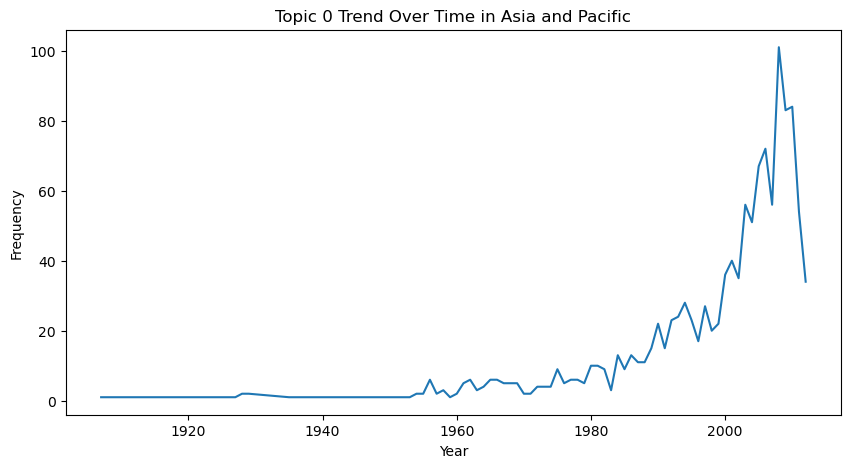

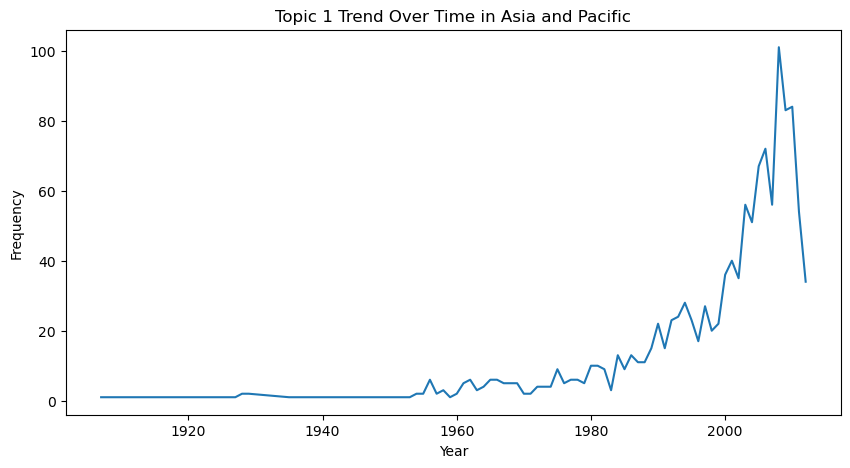

In [183]:
grouped_data = df_merged.groupby(['Region', 'Release date'])
topic_trends = grouped_data['Topic'].value_counts().unstack(level=-1)
def plot_topic_trend(region, topic):
    data = topic_trends.loc[region][topic]
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data.values)
    plt.title(f"Topic {topic} Trend Over Time in {region}")
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.show()

# Call this function with the region and topic you're interested in
# For example, to see the trend of topic 0 in 'Asia and Pacific':
plot_topic_trend('Asia and Pacific', 0)
plot_topic_trend('Asia and Pacific', 1)



4. Apply K-Mean Clustering 

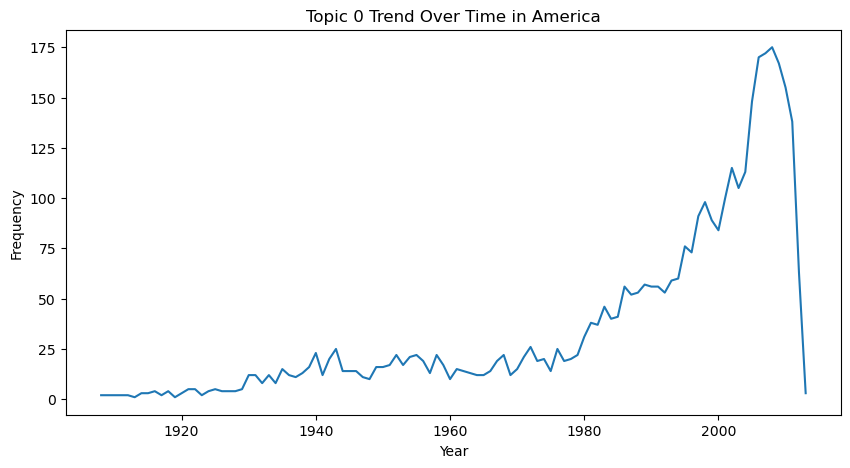

In [184]:
plot_topic_trend('America', 0)

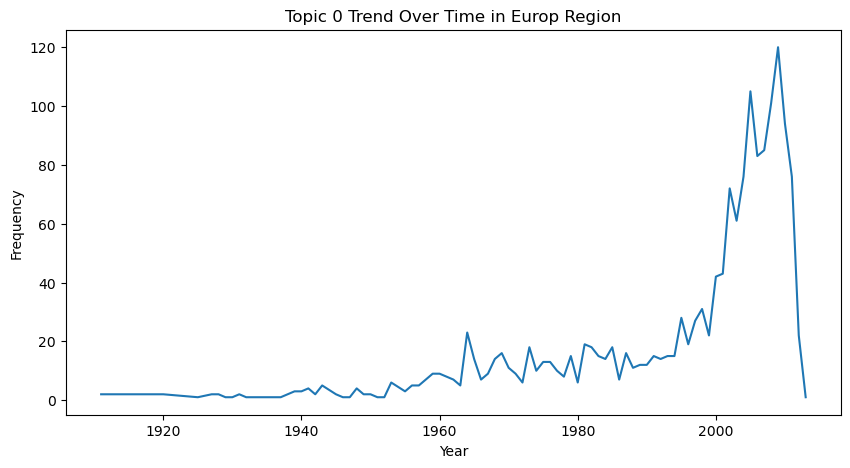

Topic                      0.0  1.0  2.0  3.0  4.0
Region       Release date                         
America      1908.0          2    2    2    2    2
             1910.0          2    2    2    2    2
             1912.0          2    2    2    2    2
             1913.0          1    1    1    1    1
             1914.0          3    3    3    3    3
...                        ...  ...  ...  ...  ...
Europ Region 2009.0        120  120  120  120  120
             2010.0         94   94   94   94   94
             2011.0         76   76   76   76   76
             2012.0         22   22   22   22   22
             2013.0          1    1    1    1    1

[263 rows x 5 columns]

In [186]:
plot_topic_trend('Europ Region', 0)
topic_trends